In [1]:
import pandas as pd
from bokeh.plotting import figure, output_file, show
from bokeh.models import ColumnDataSource, DatetimeTickFormatter
from bokeh.models.tools import HoverTool
from bokeh.io import output_notebook
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

In [2]:
output_notebook()
df = pd.read_csv('../data/central_park_weather_data.csv', dtype='object')

Loading BokehJS ...

Convert date and temperature formats. Generate columns for day, week, and month.

In [3]:
df['DATE'] = pd.to_datetime(df['DATE'])
df['weekday'] = df.DATE.dt.weekday
df['week'] = df.DATE.dt.week
df['month'] = df.DATE.dt.month
df['year'] = df.DATE.dt.year
df = df[df.DATE >= '20010101']
df['TMAX'] = df['TMAX'].astype('int')
df['TMIN'] = df['TMIN'].astype('int')
df['PRCP'] = df['PRCP'].astype('float')
df['weekday'] = df.DATE.dt.weekday
df['month'] = df.DATE.dt.month
df['week'] = df.DATE.dt.week
df.head()


STATION                         NAME  LATITUDE  LONGITUDE  \
48212  USW00094728  NY CITY CENTRAL PARK, NY US  40.77898  -73.96925   
48213  USW00094728  NY CITY CENTRAL PARK, NY US  40.77898  -73.96925   
48214  USW00094728  NY CITY CENTRAL PARK, NY US  40.77898  -73.96925   
48215  USW00094728  NY CITY CENTRAL PARK, NY US  40.77898  -73.96925   
48216  USW00094728  NY CITY CENTRAL PARK, NY US  40.77898  -73.96925   

      ELEVATION       DATE ACMH ACMH_ATTRIBUTES ACSH ACSH_ATTRIBUTES  ...  \
48212      42.7 2001-01-01  NaN             NaN  NaN             NaN  ...   
48213      42.7 2001-01-02  NaN             NaN  NaN             NaN  ...   
48214      42.7 2001-01-03  NaN             NaN  NaN             NaN  ...   
48215      42.7 2001-01-04  NaN             NaN  NaN             NaN  ...   
48216      42.7 2001-01-05  NaN             NaN  NaN             NaN  ...   

      WT19 WT19_ATTRIBUTES WT21 WT21_ATTRIBUTES   WT22 WT22_ATTRIBUTES  \
48212  NaN             NaN  NaN             NaN    NaN             NaN   
48213  NaN             NaN  NaN             NaN    NaN             NaN   
48214  NaN             NaN  NaN             NaN    NaN             NaN   
48215  NaN             NaN  NaN             NaN    NaN             NaN   
48216  NaN             NaN  NaN             NaN      1             ,,X   

      weekday week month  year  
48212       0    1     1  2001  
48213       1    1     1  2001  
48214       2    1     1  2001  
48215       3    1     1  2001  
48216       4    1     1  2001  

[5 rows x 112 columns]

List columns that do not have any missing data.

In [4]:
df.columns[~df.isnull().any()].tolist()

['STATION',
 'NAME',
 'LATITUDE',
 'LONGITUDE',
 'ELEVATION',
 'DATE',
 'PRCP',
 'PRCP_ATTRIBUTES',
 'TMAX',
 'TMAX_ATTRIBUTES',
 'TMIN',
 'TMIN_ATTRIBUTES',
 'weekday',
 'week',
 'month',
 'year']

In [5]:
df = df[df.columns[~df.isnull().any()]]
df.head()

STATION                         NAME  LATITUDE  LONGITUDE  \
48212  USW00094728  NY CITY CENTRAL PARK, NY US  40.77898  -73.96925   
48213  USW00094728  NY CITY CENTRAL PARK, NY US  40.77898  -73.96925   
48214  USW00094728  NY CITY CENTRAL PARK, NY US  40.77898  -73.96925   
48215  USW00094728  NY CITY CENTRAL PARK, NY US  40.77898  -73.96925   
48216  USW00094728  NY CITY CENTRAL PARK, NY US  40.77898  -73.96925   

      ELEVATION       DATE  PRCP PRCP_ATTRIBUTES  TMAX TMAX_ATTRIBUTES  TMIN  \
48212      42.7 2001-01-01  0.00        ,,0,2400    32             ,,0    23   
48213      42.7 2001-01-02  0.00        ,,0,2400    27             ,,0    19   
48214      42.7 2001-01-03  0.00        ,,0,2400    31             ,,0    18   
48215      42.7 2001-01-04  0.00        ,,0,2400    34             ,,0    25   
48216      42.7 2001-01-05  0.19        ,,0,2400    33             ,,0    24   

      TMIN_ATTRIBUTES  weekday  week  month  year  
48212             ,,0        0     1      1  2001  
48213             ,,0        1     1      1  2001  
48214             ,,0        2     1      1  2001  
48215             ,,0        3     1      1  2001  
48216             ,,0        4     1      1  2001

For the first iteration of the model we will be using temperature and precipitation so there is no extra work to be done.

             PRCP      TMAX      TMIN   weekday      week     month      year
PRCP     1.000000 -0.004160  0.042742  0.001151  0.020745  0.021824 -0.002243
TMAX    -0.004160  1.000000  0.957780 -0.009762  0.262122  0.261765 -0.004580
TMIN     0.042742  0.957780  1.000000 -0.008092  0.320678  0.320530  0.001719
weekday  0.001151 -0.009762 -0.008092  1.000000  0.000174  0.000501  0.000594
week     0.020745  0.262122  0.320678  0.000174  1.000000  0.971628 -0.029214
month    0.021824  0.261765  0.320530  0.000501  0.971628  1.000000 -0.029767
year    -0.002243 -0.004580  0.001719  0.000594 -0.029214 -0.029767  1.000000


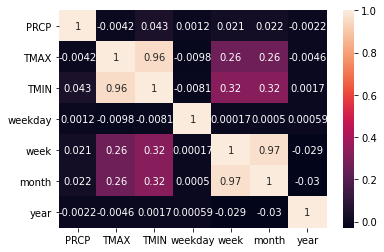

In [6]:
corr = df.corr()
print(corr)
sns.heatmap(corr, annot=True) 

Visualize the data to get a sense of how it looks. We expect it to be cyclical in nature and this helps confirm that there aren't any glaring issues with the data we collected.

In [7]:
source = ColumnDataSource(df)
p_max = figure(plot_width=1200, plot_height=600, x_axis_label='Year', y_axis_label='Maximum Temperature (F)')
p_max.xaxis.formatter=DatetimeTickFormatter()
p_max.circle(x='DATE', y='TMAX', source=source, size=10, fill_alpha=.5)
show(p_max)

In [8]:
p_min = figure(plot_width=1200, plot_height=600, x_axis_label='Year', y_axis_label='Minimum Temperature (F)')
p_min.xaxis.formatter=DatetimeTickFormatter()
p_min.circle(x='DATE', y='TMIN', source=source, size=10, fill_alpha=.5)
show(p_min)

In [9]:
p_precip = figure(plot_width=1200, plot_height=600, x_axis_label='Year', y_axis_label='Precipitation')
p_precip.xaxis.formatter=DatetimeTickFormatter()
p_precip.circle(x='DATE', y='PRCP', source=source, size=10, fill_alpha=.5)
show(p_precip)

In [10]:
P_month = figure(plot_width=1200, plot_height=600, x_axis_label='Month', y_axis_label='Maximum Temperature (F)')
P_month.xaxis.ticker = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
P_month.xaxis.major_label_overrides = {
    1: 'Jan',
    2: 'Feb',
    3: 'Mar',
    4: 'Apr',
    5: 'May',
    6: 'Jun',
    7: 'Jul',
    8: 'Aug',
    9: 'Sep',
    10: 'Oct',
    11: 'Nov',
    12: 'Dec',
}
P_month.circle(x='month', y='TMAX', source=source, size=10, fill_alpha=.5)
show(P_month)